In [39]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from matplotlib import pyplot as plt

In [3]:
with open("input.txt", encoding="utf-8") as f:
    text = f.read()

In [4]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
# unique chars in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda s: "".join(itos[i] for i in s)

print(encode("hello my name is topolino"))
print(decode(encode("hello my name is topolino")))

[46, 43, 50, 50, 53, 1, 51, 63, 1, 52, 39, 51, 43, 1, 47, 57, 1, 58, 53, 54, 53, 50, 47, 52, 53]
hello my name is topolino


In [7]:
data = torch.tensor(encode(text), dtype=torch.long)

In [8]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [10]:
x = train_data[:block_size + 1]
y = train_data[1:block_size + 1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is tensor {context} the target is {target}")

when input is tensor tensor([18]) the target is 47
when input is tensor tensor([18, 47]) the target is 56
when input is tensor tensor([18, 47, 56]) the target is 57
when input is tensor tensor([18, 47, 56, 57]) the target is 58
when input is tensor tensor([18, 47, 56, 57, 58]) the target is 1
when input is tensor tensor([18, 47, 56, 57, 58,  1]) the target is 15
when input is tensor tensor([18, 47, 56, 57, 58,  1, 15]) the target is 47
when input is tensor tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is 58


In [11]:
torch.manual_seed(1337)
batch_size = 4
block_size = 8

def get_batch(split: str = "train"):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x,y

In [14]:
xb, yb = get_batch()

In [32]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        """ 
        idx and targets have size (B, T) where B is batch size and T is block size.
        """
        # (B, T, C)
        logits = self.token_emb(idx) 
        
        loss = None
        if targets is not None:
            B, T, C = logits.shape 
            logits = logits.view(B * T, C)
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)
            
        return logits, loss 
    
    def generate(self, idx, max_new_tokens):
        """
        idx is (B, T) array of indices in the current context
        """
        for _ in range(max_new_tokens):
            logits, loss = self(idx)

            # consider only the last time steps
            logits = logits[:, -1, :] # (B, C)

            probs = F.softmax(logits, dim=-1) # (B, C)

            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        
        return idx

In [40]:
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)

torch.Size([256, 65])


In [35]:
# at the start with expect uniform distribution (maximum entropy) and so we can compute the expected loss at hand.
print(loss, -torch.log(torch.tensor(1/65.0))) 

tensor(4.1519, grad_fn=<NllLossBackward0>) tensor(4.1744)


In [47]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


YOrde,

Th h gun f boversis l'l?
3qut:
AURE b'dealy, ht cke t y cind opobare prjokis and ho hisiste,


In [41]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [48]:
batch_size = 32
losses = []
for steps in range(10000):
    xb, yb = get_batch()

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # losses.append(loss.item())
print(loss.item())

2.433521032333374


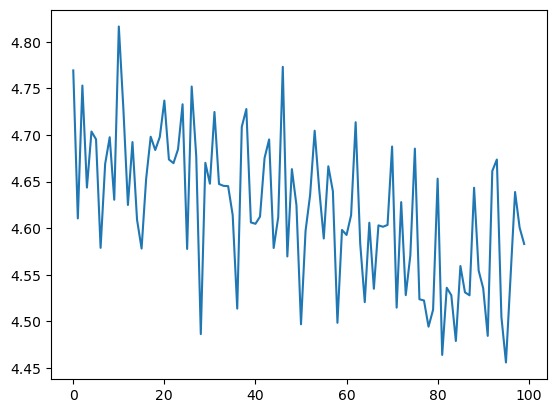

In [43]:
plt.plot(losses)

In [49]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))



Pestour geeromapr ce fad m.

Wice winve, tay tigrwieourond we fugo treare tur pe garcyonts me, ange
